## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [ ]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

#devtools::install_github("jessica-ewald/fastbmdR")
library(fastbmdR)
library(dplyr)
library(knitr)

In [2]:
df <- read.csv("../00.exploratory_analysis/inputs/proteomics_data/norm_signal_filtered.csv", sep= ',')

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]


In [15]:
## computing the BMD for the proteiomic data

models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df$Metadata_Compound)

feat_cols = colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])  
    min_val <- abs(min(compound_mat, na.rm=TRUE))  
    add_min <- min_val + 0.1 * min_val  
    mat_new <- compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] <- fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}

[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: Amperozide"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Lys05"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Imiquimod"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Cladribine"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Natamycin"
[1] "Processing compound: FCCP"
[1] "Processing compound: PEMIROLAST POTASSIUM"
[1] "Processing c

In [10]:
#write.csv(all_bmd_pass, "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/bmd_pass_protein.csv", row.names = FALSE)


## load the BMD results

all_bmd_pass <- read.csv("./outputs/bmd_pass_protein.csv", sep = ",")

In [16]:
## calculating the bmd values at real concentration

all_bmd_pass$Concentration <- NA
all_bmd_pass$Concentration_L <- NA
all_bmd_pass$Concentration_U <- NA

for (i in 1:nrow(all_bmd_pass)) {
  compound <- all_bmd_pass$compound_name[i]
  bmd <- all_bmd_pass$bmd[i]
  bmdl <- all_bmd_pass$bmdl[i]
  bmdu <- all_bmd_pass$bmdu[i]
  
  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration
  
  # Transformer en log10 (en évitant les zéros)
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose <- unique(dose)
  rank_dose <- sort(rank_dose, decreasing = TRUE)
  
  # Saut entre deux concentrations successives (log-échelle)
  if (length(rank_dose) > 1) {
    dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  } else {
    dose_spacing <- 1  # Valeur arbitraire s'il n'y a qu'une concentration
  }
  
  dose_shift <- abs(min(dose_log, na.rm = TRUE)) + dose_spacing
  
  all_bmd_pass$Concentration[i] <- 10^(bmd - dose_shift)
  all_bmd_pass$Concentration_L[i] <- 10^(bmdl - dose_shift)
  all_bmd_pass$Concentration_U[i] <- 10^(bmdu - dose_shift)
}



In [17]:
library(dplyr)

compound_count_per_protein <- all_bmd_pass %>%
  group_by(gene.id) %>%
  summarise(
    n_compounds = n_distinct(compound_name),
    compound_list = paste(unique(compound_name), collapse = ", ")
  ) %>%
  arrange(desc(n_compounds))

#write.csv(compound_count_per_protein, "../01.dose_response/outputs/compound_count_per_protein.csv", row.names = FALSE)


In [18]:
list_plot <- list()  

for (i in 1:nrow(all_bmd_pass)) {  
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$category <- all_bmd_pass$Metadata_Categories[i]
    temp$bmd <- all_bmd_pass$bmd[i]
    temp$bmd_l <- all_bmd_pass$bmdl[i]
    temp$bmd_u <- all_bmd_pass$bmdu[i]
    temp$Concentration <- all_bmd_pass$Concentration[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

# Aperçu des résultats
kable(head(final_df))



|  x| Observations|       f_x|protein |compound      |      bmd|    bmd_l|   bmd_u| Concentration|
|--:|------------:|---------:|:-------|:-------------|--------:|--------:|-------:|-------------:|
|  0|    0.1879041| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1960699| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.2082702| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1722449| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1719874| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|
|  0|    0.1936951| 0.1882725|O00175  |Actinomycin D | 4.345116| 4.243573| 4.43751|      110.6843|

In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)



n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


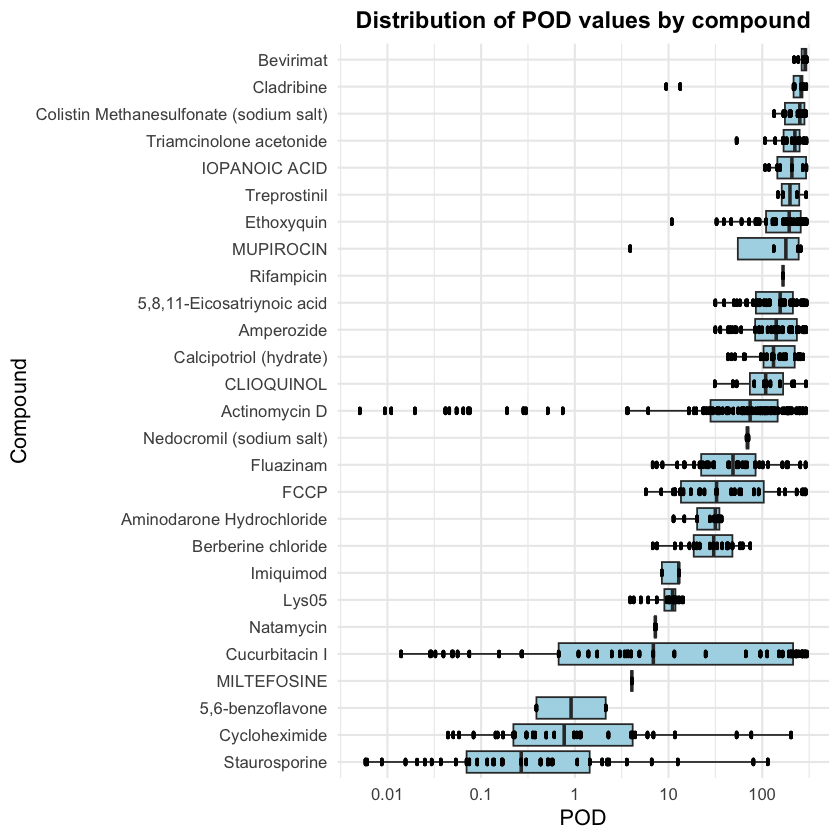

In [13]:
# boxplot of the BMD value per compound

library(ggplot2)

df_bmd <- final_df[!is.na(final_df$Concentration), ]


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  arrange(median_bmd) %>%
  pull(compound)


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD",
    y = "Compound"
  ) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold")
  )




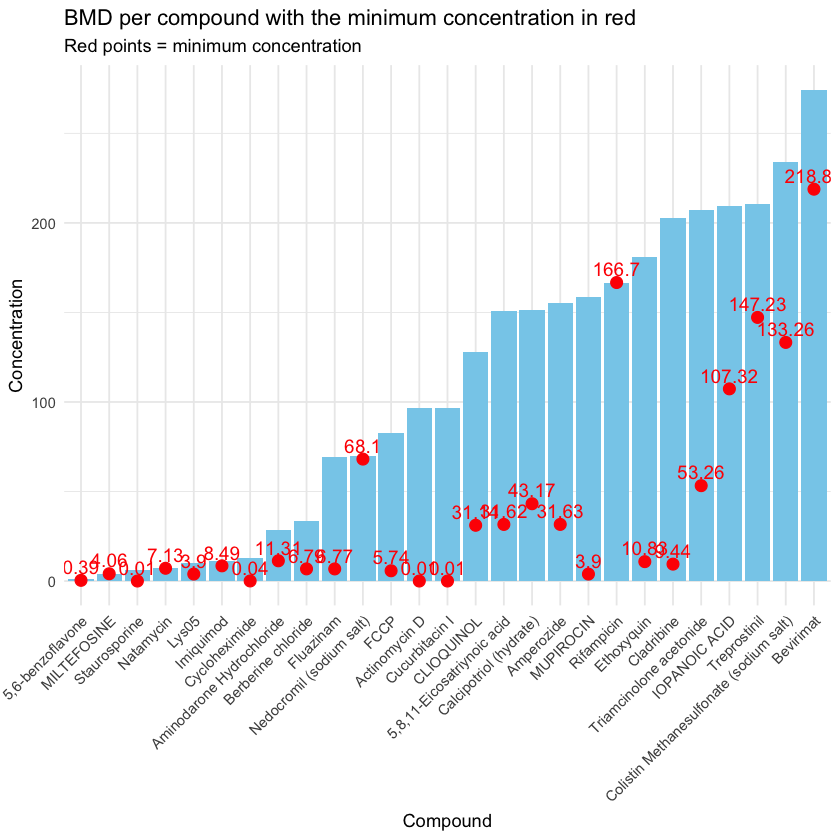

In [14]:
## Calculate the mean concentration for each compound

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  rename(compound = Metadata_Compound, category_df = Metadata_Categories)

compound_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound")


p <- ggplot(compound_summary, aes(x = reorder(compound, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration",
       subtitle = "Red points = minimum concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

print(p)


In [68]:
print(compound_summary)

# A tibble: 27 x 5
   compound         mean_concentration min_concentration nb_proteins category_df
   <chr>                         <dbl>             <dbl>       <int> <chr>      
 1 5,6-benzoflavone               1.26           0.389             2 Positive C~
 2 5,8,11-Eicosatr~             151.            31.6              33 Positive C~
 3 Actinomycin D                 96.8            0.00507         112 Positive C~
 4 Aminodarone Hyd~              28.2           11.3              11 Positive C~
 5 Amperozide                   155.            31.6              46 Positive C~
 6 Berberine chlor~              33.5            6.79             23 Positive C~
 7 Bevirimat                    274.           219.                8 Negative C~
 8 CLIOQUINOL                   128.            31.1              12 Negative C~
 9 Calcipotriol (h~             151.            43.2              25 Negative C~
10 Cladribine                   203.             9.44              9 Positive C~
# i 17 mo

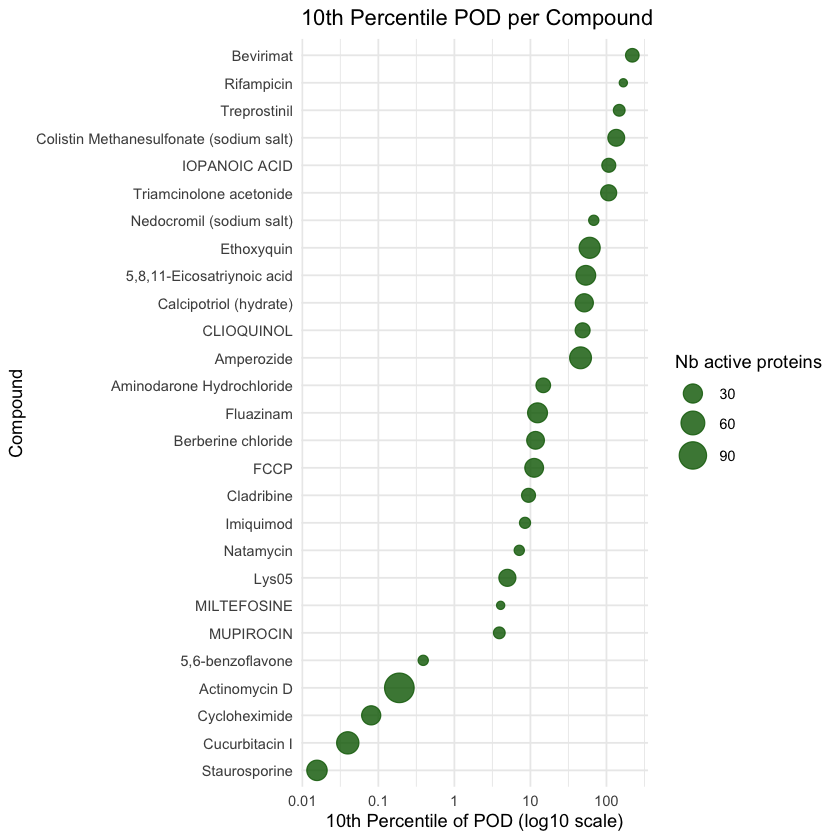

In [15]:
### Calculate the 10th percentile of BMD for each compound across all protein bmds 

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  rename(compound = Metadata_Compound, category = Metadata_Categories)

pod_summary <- final_df %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  left_join(compound_categories, by = "compound") %>%
  arrange(desc(nb_proteins))


#print(pod_summary, n=Inf)

ggplot(pod_summary, aes(x = pod_10th_percentile, y = reorder(compound, pod_10th_percentile))) +
  geom_point(aes(size = nb_proteins), color = "darkgreen", alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) +  # ajuste la taille des points ici
  labs(title = "10th Percentile POD per Compound",
       x = "10th Percentile of POD (log10 scale)",
       y = "Compound",
       size = "Nb active proteins") +
  theme_minimal()



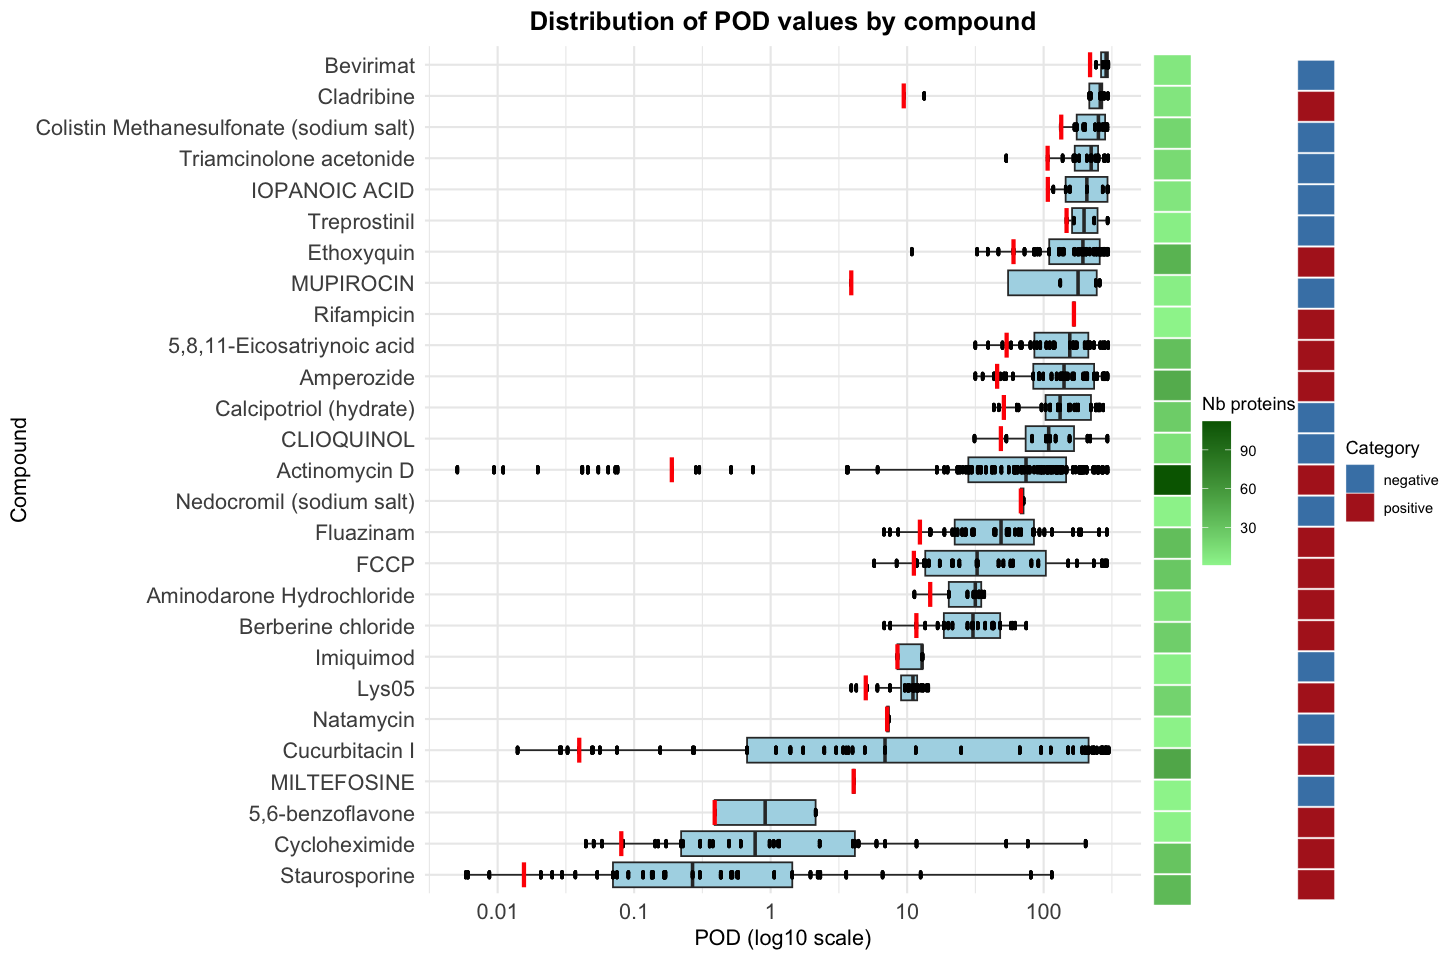

In [51]:
library(cowplot)
library(tidyr)


df_bmd <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0)


compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  filter(!Metadata_Compound %in% c("Troglitazone", "PEMIROLAST POTASSIUM", 'DMSO')) %>%
  rename(compound = Metadata_Compound, category = Metadata_Categories) %>%
  mutate(category = case_when(
    grepl("Positive", category, ignore.case = TRUE) ~ "positive",
    grepl("Negative", category, ignore.case = TRUE) ~ "negative",
    TRUE ~ "other"
  ))


compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  right_join(compound_categories, by = "compound") %>%
  mutate(median_bmd = ifelse(is.na(median_bmd), Inf, median_bmd)) %>%
  arrange(median_bmd) %>%
  pull(compound)


pod_summary_raw <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0) %>%
  group_by(compound) %>%
  summarise(
    pod_10th = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  )

pod_summary <- compound_categories %>%
  left_join(pod_summary_raw, by = "compound") %>%
  mutate(category = replace_na(category, "other")) %>%
  mutate(
    compound = factor(compound, levels = compound_order),
    nb_proteins = replace_na(nb_proteins, 0)
  )


df_bmd$compound <- factor(df_bmd$compound, levels = compound_order)


p_main <- ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  geom_segment(data = pod_summary %>% filter(!is.na(pod_10th)), 
               aes(x = log10(pod_10th), xend = log10(pod_10th),
                   y = as.numeric(compound) - 0.4, 
                   yend = as.numeric(compound) + 0.4),
               color = "red", linewidth = 1.2) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD (log10 scale)",
    y = "Compound"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.y = element_text(size = 13),
    axis.text.x = element_text(size = 13),
    plot.title = element_text(hjust = 0.5, face = "bold")
  )


p_proteins <- ggplot(pod_summary, aes(y = compound, x = 1, fill = nb_proteins)) +
  geom_tile(color = "white", height = 0.95) +
  scale_fill_gradient(name = "Nb proteins", low = "#9bf29b", high = "darkgreen") +
  theme_void() +
  theme(legend.position = "right") +
  coord_fixed(ratio = 0.85)


p_category <- ggplot(pod_summary, aes(y = compound, x = 1, fill = category)) +
  geom_tile(color = "white", height =0.95) +
  scale_fill_manual(
    name = "Category",
    values = c("positive" = "firebrick", "negative" = "steelblue", "other" = "grey70")
  ) +
  theme_void() +
  theme(legend.position = "right") +
  coord_fixed(ratio = 0.85)



final_plot <- plot_grid(
  p_main,
  plot_grid(p_proteins, p_category, ncol = 2, rel_widths = c(0.05, 0.05)),
  ncol = 2,
  rel_widths = c(0.8, 0.2)
)

options(repr.plot.width = 12, repr.plot.height = 8)  # pour R Markdown / notebooks
print(final_plot)


Warning message:
"Vectorized input to `element_text()` is not officially supported.
i Results may be unexpected or may change in future versions of ggplot2."


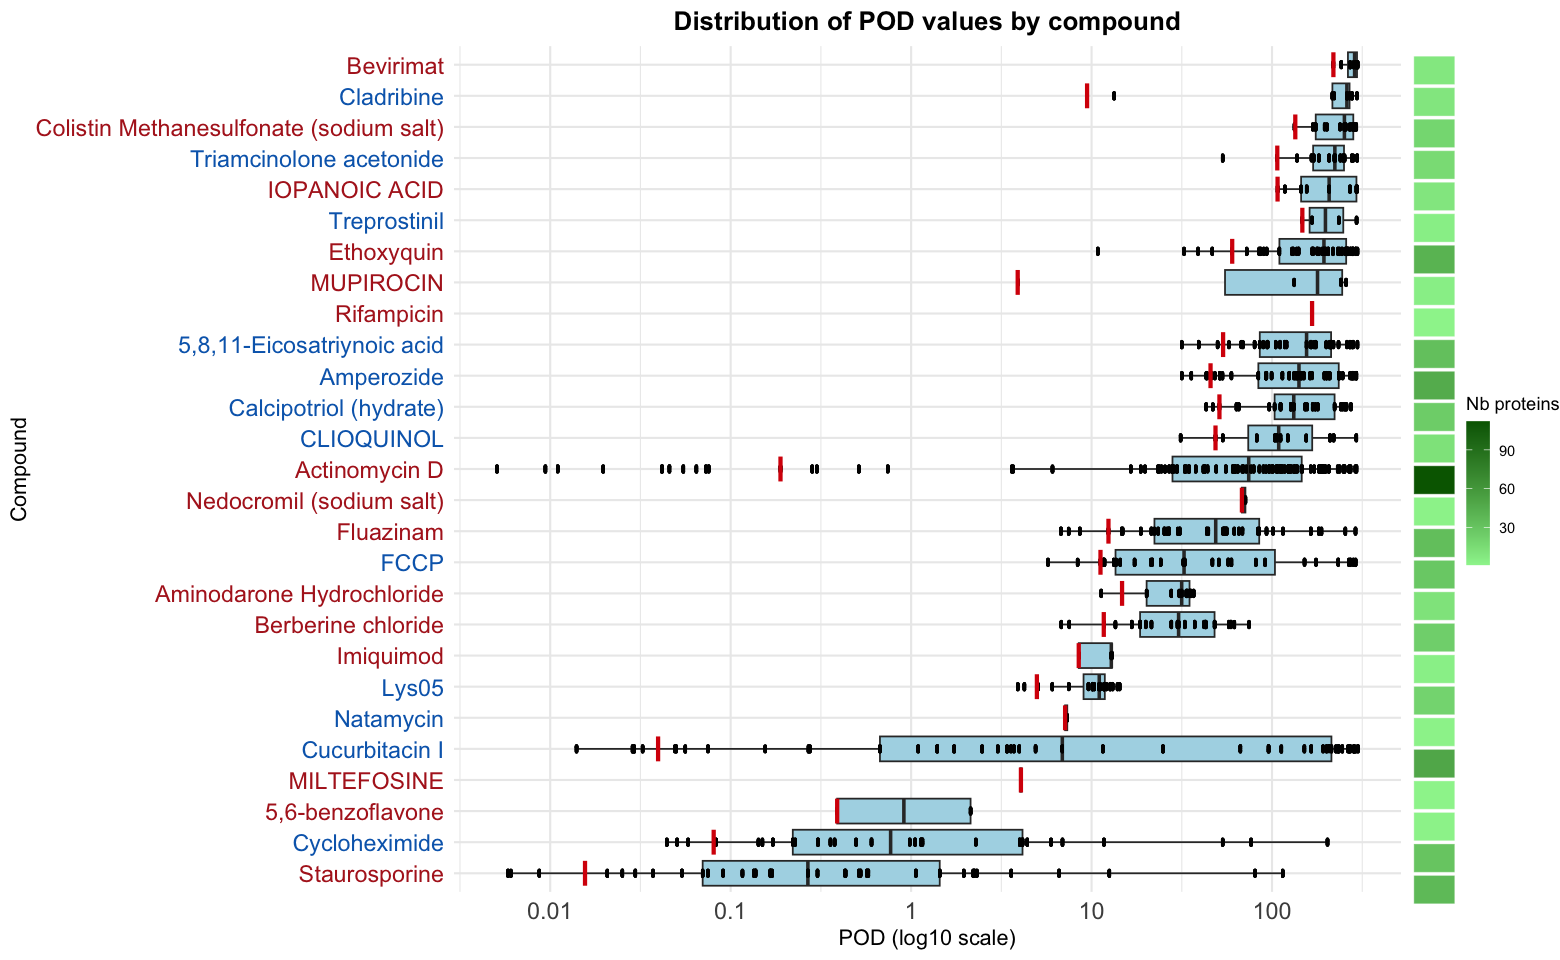

In [ ]:
library(tidyverse)
library(cowplot)

df_bmd <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0)

compound_categories <- df %>%
  select(Metadata_Compound, Metadata_Categories) %>%
  distinct() %>%
  filter(!Metadata_Compound %in% c("Troglitazone", "PEMIROLAST POTASSIUM", "DMSO")) %>%
  rename(compound = Metadata_Compound, category = Metadata_Categories) %>%
  mutate(category = case_when(
    grepl("Positive", category, ignore.case = TRUE) ~ "positive",
    grepl("Negative", category, ignore.case = TRUE) ~ "negative",
    TRUE ~ "other"
  ))

compound_order <- df_bmd %>%
  group_by(compound) %>%
  summarise(median_bmd = median(Concentration, na.rm = TRUE)) %>%
  right_join(compound_categories, by = "compound") %>%
  mutate(median_bmd = ifelse(is.na(median_bmd), Inf, median_bmd)) %>%
  arrange(median_bmd) %>%
  pull(compound)

pod_summary_raw <- final_df %>%
  filter(!is.na(Concentration), Concentration > 0) %>%
  group_by(compound) %>%
  summarise(
    pod_10th = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  )


pod_summary <- compound_categories %>%
  left_join(pod_summary_raw, by = "compound") %>%
  mutate(
    category = replace_na(category, "other"),
    compound = factor(compound, levels = compound_order),
    nb_proteins = replace_na(nb_proteins, 0),
    color_category = case_when(
      category == "positive" ~ "firebrick",
      category == "negative" ~ "#0468ba",
      TRUE ~ "grey30"
    )
  )

df_bmd <- df_bmd %>%
  mutate(compound = factor(compound, levels = compound_order))


p_main <- ggplot(df_bmd, aes(x = log10(Concentration), y = compound)) +
  geom_boxplot(fill = "lightblue", outlier.shape = NA, width = 0.8) +
  geom_jitter(width = 0, height = 0.1, alpha = 0.3, color = "black", size = 0.3) +
  geom_segment(data = pod_summary %>% filter(!is.na(pod_10th)), 
               aes(x = log10(pod_10th), xend = log10(pod_10th),
                   y = as.numeric(compound) - 0.4, 
                   yend = as.numeric(compound) + 0.4),
               color = "#d70307", linewidth = 1.2) +
  scale_x_continuous(
    breaks = log10(c(0.001, 0.01, 0.1, 1, 10, 100)),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  labs(
    title = "Distribution of POD values by compound",
    x = "POD (log10 scale)",
    y = "Compound"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(
      size = 14,
      color = pod_summary$color_category
    ),
    plot.title = element_text(hjust = 0.5, face = "bold")
  )

p_proteins <- ggplot(pod_summary, aes(y = compound, x = 1, fill = nb_proteins)) +
  geom_tile(color = "white", height = 0.9) +
  scale_fill_gradient(name = "Nb proteins", low = "#9bf29b", high = "darkgreen") +
  theme_void() +
  theme(legend.position = "right") +
  theme(legend.key.width = unit(0.5, "cm")) +
  coord_fixed(ratio = 0.77)

final_plot <- plot_grid(
  p_main,
  p_proteins,
  ncol = 2,
  rel_widths = c(0.905, 0.095)  # Moins de place pour la heatmap
)


options(repr.plot.width = 13, repr.plot.height = 8)
print(final_plot)


In [ ]:
#write.csv(pod_summary, "/Users/grigoryanmariam/Downloads/proteomic_bmd_dose_results.csv", row.names = FALSE)


In [ ]:
## we now add the protein name to the all_bmd_pass dataframe and save it all in a csv file

## all done, just read the file bmd_pass_with_protein_name.csv

library(readr)

gene_info <- read_csv("../00.exploratory_analysis/outputs/gene_ids.csv")  

all_bmd_pass_neww <- all_bmd_pass %>%
  left_join(gene_info %>% select(uniprot_id, protein_name),
            by = c("gene.id" = "uniprot_id"))

all_bmd_pass_neww <- all_bmd_pass_neww %>%
  mutate(protein = ifelse(is.na(protein_name), gene.id, protein_name)) %>%
  select(-protein_name)  # on garde gene.id


#write.csv(all_bmd_pass_neww, "./outputs/bmd_pass_with_protein_name.csv", row.names = FALSE)

There are two protein ids: P01137.1 and P40933.1 that we don't have the name in gene_ids.csv. For those I put the name of proteins P01137 and P40933. 

In [ ]:
## load the parameters of the bmd curves with protein names, concentration and bmd values

all_bmd_pass_new <- read.csv("./outputs/bmd_pass_with_protein_name.csv", sep = ",")

In [ ]:
# not clustered heatmap of POD values using ggplot2

library(tidyverse)
library(pheatmap)
library(RColorBrewer)


compound_name <- unique(all_bmd_pass_new$compound_name)

active_prots <- all_bmd_pass_new %>%
  select(Protein = gene.id, Compound = compound_name, Concentration)

active_prots <- active_prots %>%
  filter(Compound %in% compound_name)

heatmap_data <- active_prots %>%
  pivot_wider(names_from = Compound, values_from = Concentration) %>%
  column_to_rownames("Protein")


max_value <- max(heatmap_data, na.rm = TRUE)


heatmap_data[is.na(heatmap_data)] <- max_value + 100


heatmap_long <- heatmap_data %>%
  rownames_to_column("Protein") %>%
  pivot_longer(cols = -Protein, names_to = "Compound", values_to = "POD")

p <- ggplot(heatmap_long, aes(x = Compound, y = Protein, fill = log10(POD))) + 
  geom_tile() + 
  theme_minimal() + 
  theme(
    axis.text.x = element_text(angle = 70, hjust = 1, size = 15),   
    axis.text.y = element_text(size = 12),  
    plot.title = element_text(size = 18),  
    axis.title.x = element_text(size = 16), 
    axis.title.y = element_text(size = 16)  
  ) +
  labs(title = "Heatmap of PODs") +
  scale_fill_gradientn(
    colors = rev(RColorBrewer::brewer.pal(16, "YlGnBu")),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  )


ggsave("heatmap_proteins.png", plot = p, width = 20, height = 30, dpi = 300) 


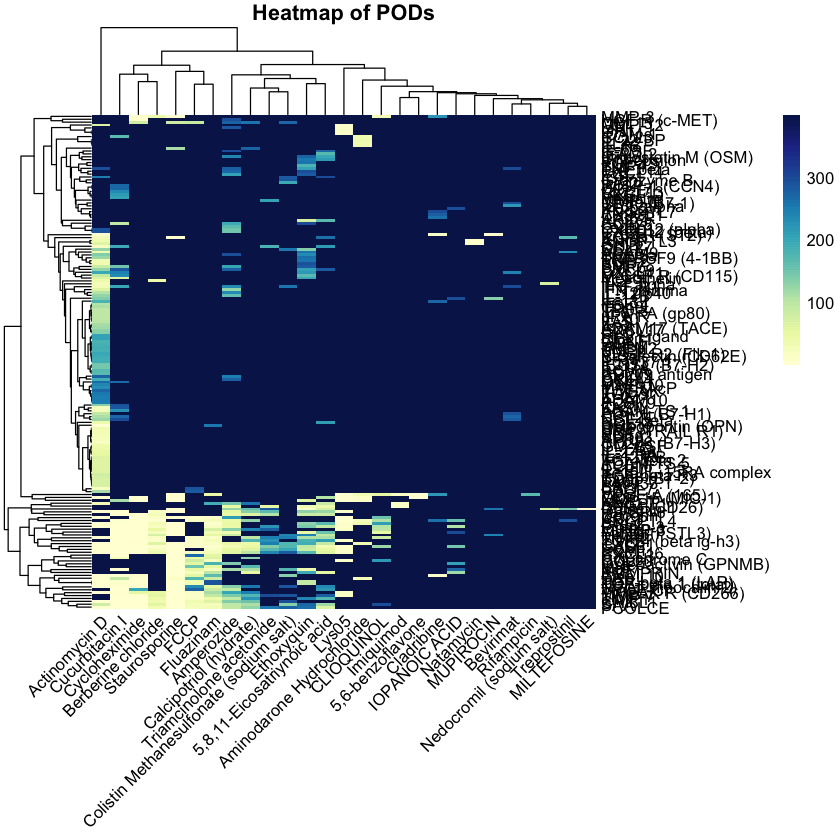

In [84]:
## clustered heatmap of POD values using pheatmap


library(pheatmap)

compound_name <- unique(all_bmd_pass_new$compound_name)
active_prots <- all_bmd_pass_new %>%
  select(Protein = protein, Compound = compound_name, Concentration)


active_prots <- active_prots %>%
  filter(Compound %in% compound_name)
heatmap_data <- active_prots %>%
  pivot_wider(names_from = Compound, values_from = Concentration) %>%
  column_to_rownames("Protein")


max_value <- max(heatmap_data, na.rm = TRUE)


heatmap_data[is.na(heatmap_data)] <- max_value + 100

heatmap_matrix <- as.matrix(heatmap_data)

pheatmap(
  heatmap_matrix,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  display_numbers = FALSE,
  color = colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(100),
  main = "Heatmap of PODs",
  fontsize_row = 10,
  fontsize_col = 10,
  angle_col = 45,
  na_col = "grey90"
)

In [91]:
# saving the heatmap as a png file
heatmap_plot <- pheatmap(heatmap_matrix,
                         cluster_rows = TRUE,
                         cluster_cols = TRUE,
                         display_numbers = FALSE,
                         color = colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(100),
                         main = "Heatmap of POD values",
                         fontsize_row = 11,
                         fontsize_col = 14,
                         angle_col = 45,
                         na_col = "grey90",
                         silent = TRUE) 

png("./heatmap_protein_new.png", width = 15 * 1200, height = 26 * 1200, res = 1200)
grid::grid.newpage()
grid::grid.draw(heatmap_plot$gtable)
dev.off()


pdf 
  2

In [ ]:

#write.csv(final_df, "./outputs/results_POD_prot.csv", row.names = FALSE)

### Comparing the 10th Percentile of protein PODs and MD of CP data


In [21]:

library(patchwork)

## loading the results of MD PODs

final_df_md <- read.csv("./outputs/results_MD_CP_data.csv", header = TRUE)

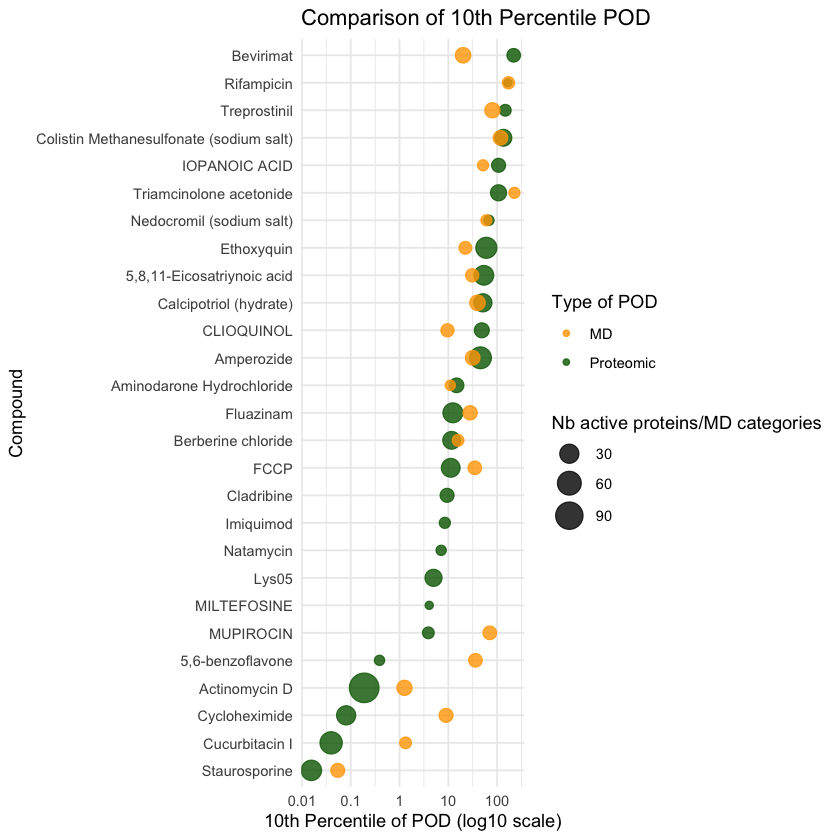

In [27]:
#
pod_summary_proteins <- final_df %>%
  group_by(compound = compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  mutate(type = "Proteomic")


pod_summary_md <- final_df_md %>%
  group_by(compound = compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein)
  ) %>%
  mutate(type = "MD")

pod_summary_combined <- bind_rows(pod_summary_proteins, pod_summary_md)

compound_order <- pod_summary_combined %>%
  filter(type == "Proteomic") %>%
  arrange(pod_10th_percentile) %>%
  pull(compound)


ggplot(pod_summary_combined, aes(x = pod_10th_percentile, y = factor(compound, levels = compound_order))) +
  geom_point(aes(color = type, size = nb_proteins), alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_color_manual(values = c("Proteomic" = "darkgreen", "MD" = "orange")) +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Comparison of 10th Percentile POD",
    x = "10th Percentile of POD (log10 scale)",
    y = "Compound",
    color = "Type of POD",
    size = "Nb active proteins/MD categories"
  ) +
  theme_minimal()


`geom_smooth()` using formula = 'y ~ x'


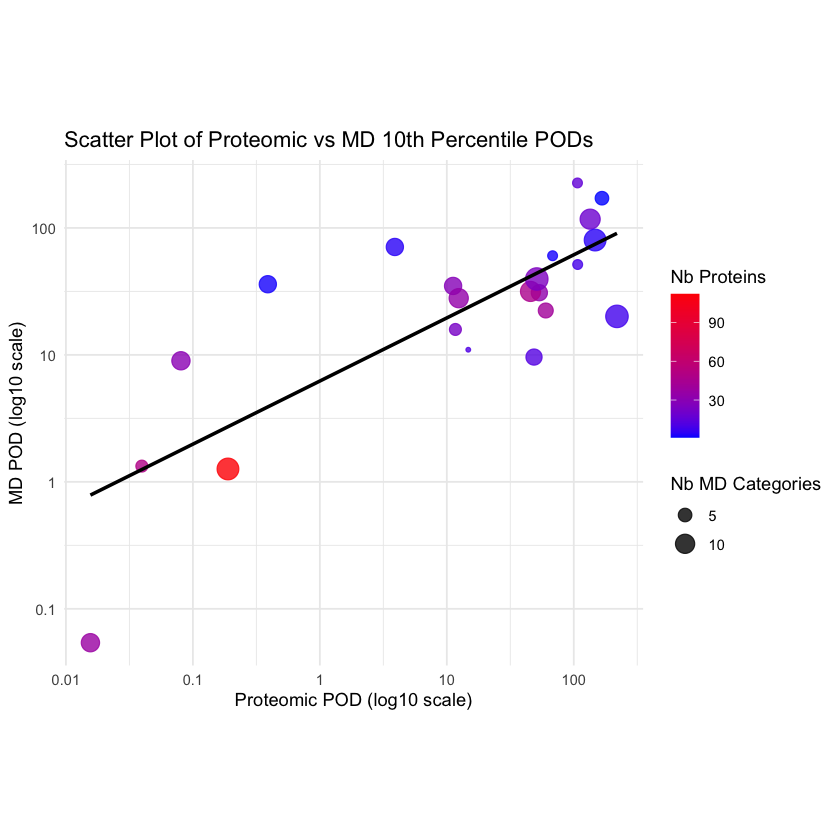

In [ ]:
# Scatter plot comparing proteomic and MD 10th percentile PODs with linear regression line


pod_summary_md_renamed <- pod_summary_md %>%
  select(compound, pod_10th_percentile, nb_proteins) %>%
  rename(
    pod_10th_percentile_MD = pod_10th_percentile,
    nb_category_MD = nb_proteins 
  )



merged_table <- pod_summary_proteins %>%
  inner_join(pod_summary_md_renamed, by = "compound")



ggplot(merged_table, aes(x = pod_10th_percentile, y = pod_10th_percentile_MD)) +
    geom_point(aes(color = nb_proteins, size = nb_category_MD), alpha = 0.8) +
    geom_smooth(method = "lm", color = "black", se = FALSE) +
    scale_x_continuous(
        trans = "log10",
        breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
        labels = c("0.001", "0.01", "0.1", "1", "10", "100")
    ) +
    scale_y_continuous(
        trans = "log10",
        breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
        labels = c("0.001", "0.01", "0.1", "1", "10", "100")
    ) +
    scale_color_gradient(low = "blue", high = "red") +
    labs(
        title = "Scatter Plot of Proteomic vs MD 10th Percentile PODs",
        x = "Proteomic POD (log10 scale)",
        y = "MD POD (log10 scale)",
        color = "Nb Proteins",
        size = "Nb MD Categories"
    ) +
    theme_minimal() +
    coord_fixed()  

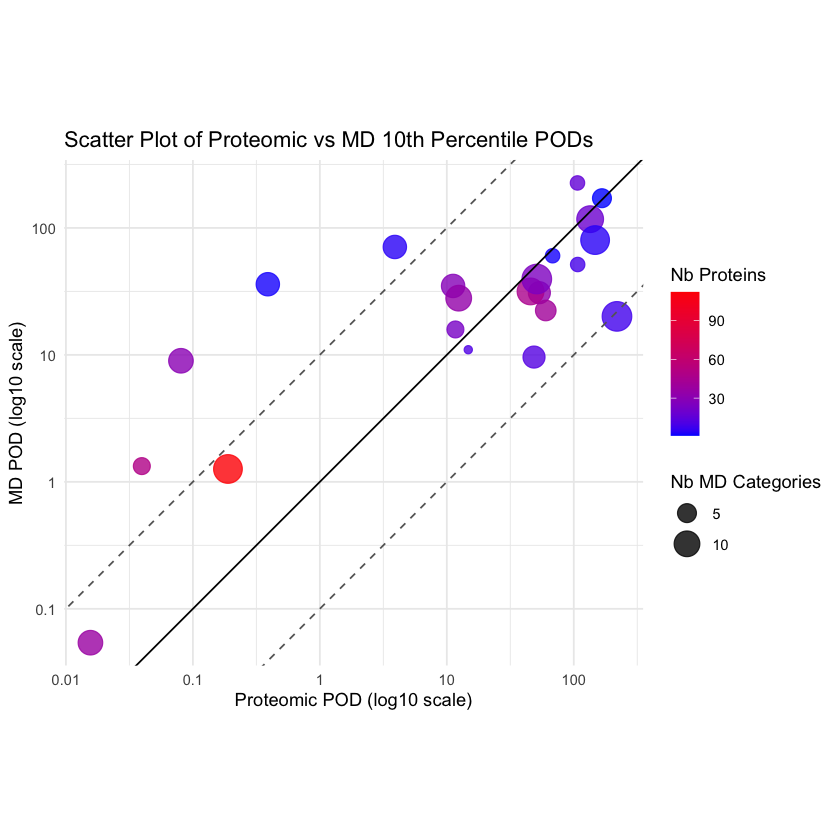

In [59]:
ggplot(merged_table, aes(x = pod_10th_percentile, y = pod_10th_percentile_MD)) +
  geom_point(aes(color = nb_proteins, size = nb_category_MD), alpha = 0.8) +
  
  # Ligne 1:1
  geom_abline(slope = 1, intercept = 0, color = "black") +
  
  # Ligne y = 10x
  geom_abline(slope = 1, intercept = log10(10), linetype = "dashed", color = "gray40") +

  geom_abline(slope = 1, intercept = - log10(10), linetype = "dashed", color = "gray40") +
  
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_y_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_color_gradient(low = "blue", high = "red") +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Scatter Plot of Proteomic vs MD 10th Percentile PODs",
    x = "Proteomic POD (log10 scale)",
    y = "MD POD (log10 scale)",
    color = "Nb Proteins",
    size = "Nb MD Categories"
  ) +
  theme_minimal() +
  coord_fixed()


In [58]:
correlation_test <- cor.test(merged_table$pod_10th_percentile, merged_table$pod_10th_percentile_MD, use = "complete.obs", method = "pearson")
correlation <- correlation_test$estimate
p_value <- correlation_test$p.value

print(paste("Correlation between Proteomic and MD 10th Percentile PODs:", correlation))
print(paste("P-value of the correlation:", p_value))

[1] "Correlation between Proteomic and MD 10th Percentile PODs: 0.542829261763974"
[1] "P-value of the correlation: 0.00904274962782758"


In the context of our data, the 10th percentile PODs from proteomic data and MD data are moderately related but there is still variability that is not explained by the correlation.